In [2]:
import modulo_conn_sql as mcq
import numpy as np
import pandas as pd 
import datetime 
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns
from scipy import stats
import tqdm
import inspect
import warnings
from scipy.stats import johnsonsu   
import sqlalchemy as sa
import urllib
from sklearn.metrics import mean_squared_error
from pandas.tseries.offsets import MonthEnd
from pandas.tseries.offsets import MonthBegin

warnings.filterwarnings('ignore')

def conectarSQL():
    conn = mcq.ConexionSQL()
    cursor = conn.getCursor()
    return cursor

#Query BD SQL-Server Cemex
def querySQL(query, parametros):
    #Conectar con base sql y ejecutar consulta
    cursor = conectarSQL()
    try:
        cursor.execute(query, parametros)
        #obtener nombre de columnas
        names = [ x[0] for x in cursor.description]
        
        #Reunir todos los resultado en rows
        rows = cursor.fetchall()
        resultadoSQL = []
            
        #Hacer un array con los resultados
        while rows:
            resultadoSQL.append(rows)
            if cursor.nextset():
                rows = cursor.fetchall()
            else:
                rows = None
                
        #Redimensionar el array para que quede en dos dimensiones
        resultadoSQL = np.array(resultadoSQL)
        resultadoSQL = np.reshape(resultadoSQL, (resultadoSQL.shape[1], resultadoSQL.shape[2]) )
    finally:
            if cursor is not None:
                cursor.close()
    return pd.DataFrame(resultadoSQL, columns = names)

In [3]:
#Variables 
pais='Colombia'

#rangos de fecha
#fin_historia = datetime.date.today()
fin_historia = datetime.date(2022,5,31)
#inicio_historia = fin_historia - datetime.timedelta(30 * 2) - MonthBegin(1)
inicio_historia= datetime.date(2022,4,1)

#Dataset de los consumos
df = querySQL( "SELECT * FROM AT51_Z1045_CONSU_TICKET2 WHERE FechaInicio between ? and ?" , (inicio_historia.strftime("%Y-%m-%d"), fin_historia.strftime("%Y-%m-%d") ) )
df['year_month'] = df.FechaInicio.dt.to_period('M')
df['TipoMaterial'] = df['TipoMaterial'].str.strip()
df['TextoBreveMaterial'] = df['TextoBreveMaterial'].str.strip()


In [7]:
df['TipoMaterial'].unique()

array(['ADI', 'CEM', 'AGU', 'GRA', 'ARE', 'FIB', 'ADC'], dtype=object)

## ¿Qué tanta variedad de MMPP hay?

### Aditivos

In [5]:
df_aditivos = df[df['TipoMaterial'] == 'ADI']
df_aditivos

,ID,FechaInicio,FechaFin,HoraInicio,HoraFin,OrdenProduccion,Entrega,Centro,TipoMaterial,UnidadMedida,Estatus,CantidadReal,Material,TextoBreveMaterial,m3producidos,DescTecnica,year_month
0,4153415,2022-04-22,2022-04-22,1900-01-01 12:26:05,1900-01-01 12:29:52,700043841587,211735679,F014,ADI,ML,Normal,6003,1400005501,"ADI. CONC. ESP.,EUCON WR 85,EUCLID,GRANE",6,1-210-5-A-28-10-0-3-000,2022-04
3,4153418,2022-04-22,2022-04-22,1900-01-01 05:34:35,1900-01-01 06:38:56,700043847278,211717535,F014,ADI,ML,Normal,7960.5,1400005501,"ADI. CONC. ESP.,EUCON WR 85,EUCLID,GRANE",8,1-210-5-A-28-10-0-3-000,2022-04
6,4153421,2022-04-22,2022-04-22,1900-01-01 05:34:35,1900-01-01 06:38:56,700043847278,211717535,F014,ADI,ML,Normal,3319.68,10037634,ISORETARD 212,8,1-210-5-A-28-10-0-3-000,2022-04
10,4153425,2022-04-22,2022-04-22,1900-01-01 06:22:03,1900-01-01 06:28:01,700043847279,211718071,F014,ADI,ML,Normal,3319.68,10037634,ISORETARD 212,8,1-210-5-A-28-10-0-3-000,2022-04
11,4153426,2022-04-22,2022-04-22,1900-01-01 06:22:03,1900-01-01 06:28:01,700043847279,211718071,F014,ADI,ML,Normal,7917,1400005501,"ADI. CONC. ESP.,EUCON WR 85,EUCLID,GRANE",8,1-210-5-A-28-10-0-3-000,2022-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165754,4159549,2022-04-22,2022-04-22,1900-01-01 14:45:17,1900-01-01 14:52:05,700043794448,211743847,F014,ADI,ML,Normal,1837.68,10037634,ISORETARD 212,6,O-210-5-A-18-18-1-3-000,2022-04
165756,4160386,2022-05-04,2022-05-04,1900-01-01 09:00:08,1900-01-01 09:11:47,700044025007,212365194,F055,ADI,ML,Normal,2854.05,10037639,CX ISOFLOW 751,7,1-140-5-A-28-15-1-3-000,2022-05
165758,4160388,2022-05-04,2022-05-04,1900-01-01 09:00:08,1900-01-01 09:11:47,700044025007,212365194,F055,ADI,ML,Normal,5549.27,10037637,ISOPLAST 159,7,1-140-5-A-28-15-1-3-000,2022-05
165766,4160396,2022-05-04,2022-05-04,1900-01-01 12:41:53,1900-01-01 12:55:53,700043960022,212384078,F010,ADI,ML,Normal,9724.77,10037637,ISOPLAST 159,8,1-210-5-D-28-15-1-3-000,2022-05


Text(0.5, 1.0, '¿Cual es el producto que más demanda tiene?')

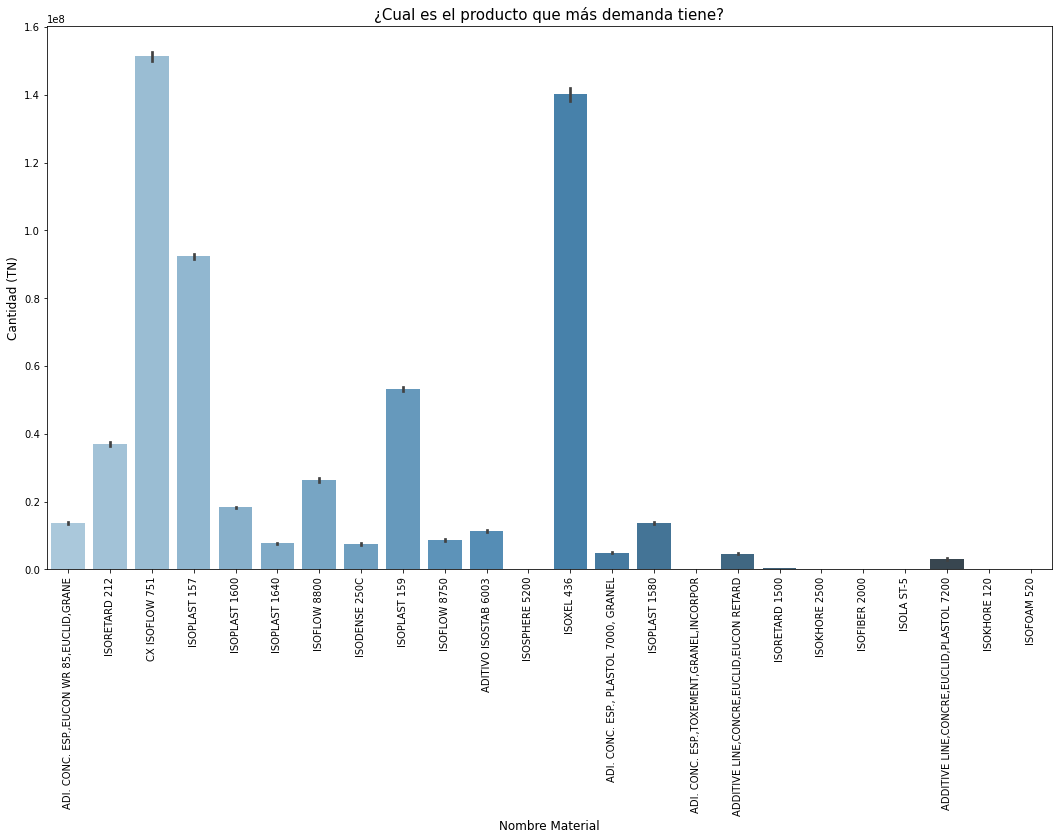

In [6]:
plt.figure(figsize=(18,10))
fig1 = sns.barplot(x="TextoBreveMaterial", y="CantidadReal", data = df_aditivos, estimator= sum, palette="Blues_d")
fig1.set_xticklabels(fig1.get_xticklabels() , rotation=90);
plt.ylabel("Cantidad (TN)", size=12)
plt.xlabel("Nombre Material", size=12)
plt.title("¿Cual es el producto que más demanda tiene?", size=15)

## Grava

Text(0.5, 1.0, '¿Cual es el producto que más demanda tiene?')

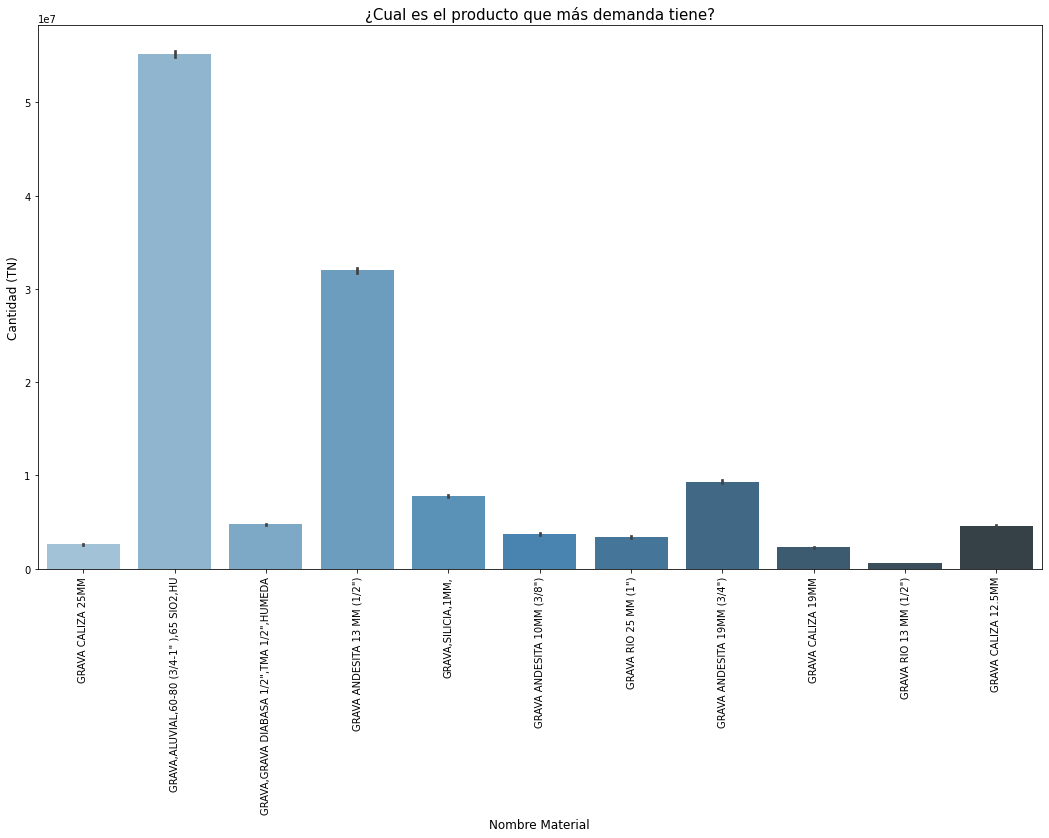

In [8]:
df_grava = df[df['TipoMaterial'] == 'GRA'] 
plt.figure(figsize=(18,10))
fig1 = sns.barplot(x="TextoBreveMaterial", y="CantidadReal", data = df_grava, estimator= sum, palette="Blues_d")
fig1.set_xticklabels(fig1.get_xticklabels() , rotation=90);
plt.ylabel("Cantidad (TN)", size=12)
plt.xlabel("Nombre Material", size=12)
plt.title("¿Cual es el producto que más demanda tiene?", size=15)

## Arena

Text(0.5, 1.0, '¿Cual es el producto que más demanda tiene?')

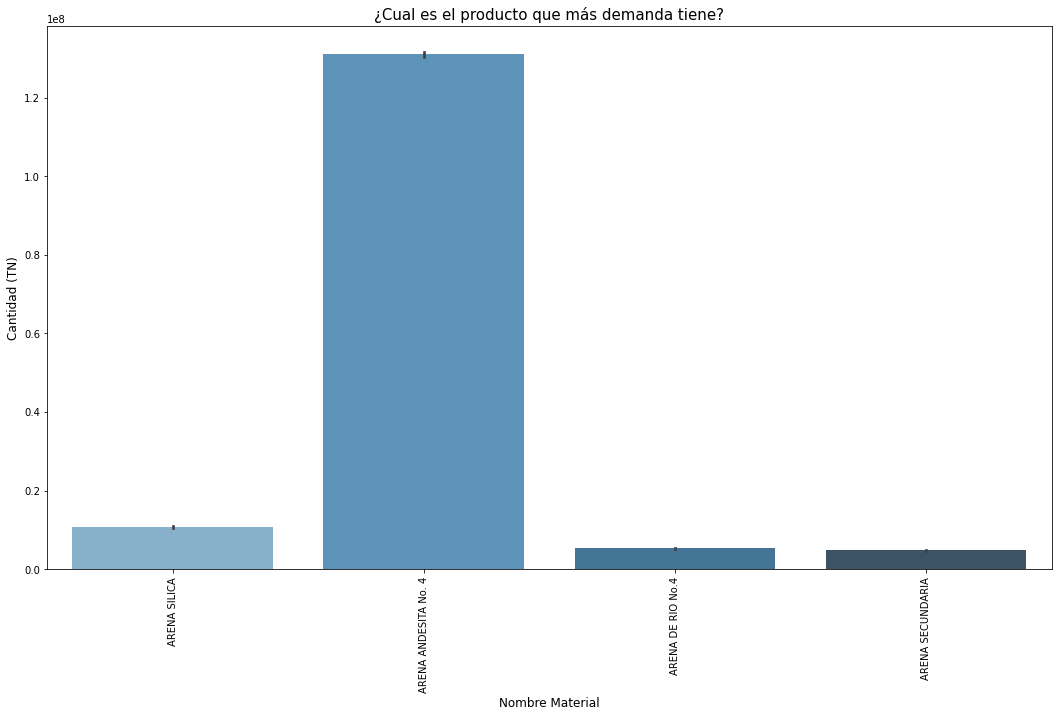

In [9]:
df_arena = df[df['TipoMaterial'] == 'ARE'] 
plt.figure(figsize=(18,10))
fig1 = sns.barplot(x="TextoBreveMaterial", y="CantidadReal", data = df_arena, estimator= sum, palette="Blues_d")
fig1.set_xticklabels(fig1.get_xticklabels() , rotation=90);
plt.ylabel("Cantidad (TN)", size=12)
plt.xlabel("Nombre Material", size=12)
plt.title("¿Cual es el producto que más demanda tiene?", size=15)

## Cemento

Text(0.5, 1.0, '¿Cual es el producto que más demanda tiene?')

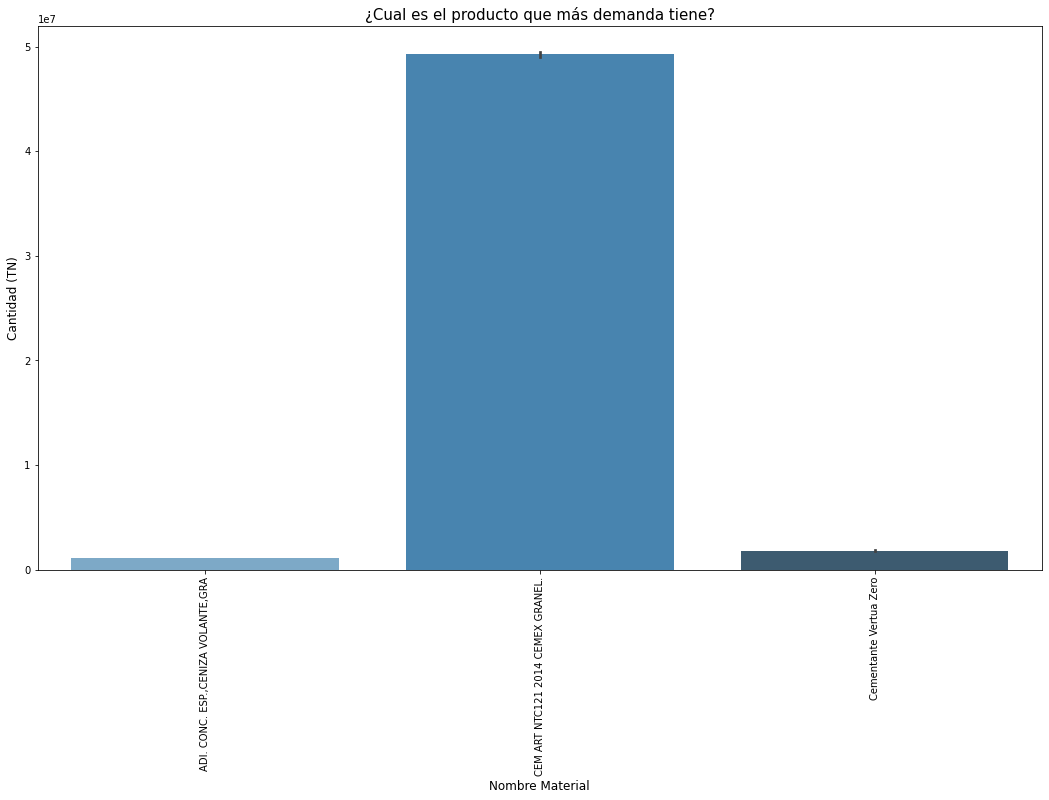

In [10]:
df_cemento = df[df['TipoMaterial'] == 'CEM'] 
plt.figure(figsize=(18,10))
fig1 = sns.barplot(x="TextoBreveMaterial", y="CantidadReal", data = df_cemento, estimator= sum, palette="Blues_d")
fig1.set_xticklabels(fig1.get_xticklabels() , rotation=90);
plt.ylabel("Cantidad (TN)", size=12)
plt.xlabel("Nombre Material", size=12)
plt.title("¿Cual es el producto que más demanda tiene?", size=15)